In [2]:
import os
import re
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from results_utils import create_dir, walk_paths

In [3]:
realpath = os.path.dirname('.')
save_fig_dir = os.path.join(realpath, "figures")
create_dir([save_fig_dir])

# Preference Overestimation

In [4]:
savename = "fig_5-overestimation"
logs_path = "result_logs/3-overestimation"
logs_dirpath = os.path.join(realpath, logs_path)

In [5]:
def loaddata(dirpath, filenames, epoch_start=96, metric="ctr"):
    pattern_neg = re.compile("\[.*(\d+)\]")
    pattern_epoch = re.compile("Epoch: \[(\d+)]")
    pattern_info = re.compile("Info: \[(\{.+\})]")
    pattern_array = re.compile("array\((.+?)\)")

    df = pd.DataFrame()
    for filename in filenames:
        n_neg = int(re.search(pattern_neg, filename).group(1))
        filepath = os.path.join(dirpath, filename)
        with open(filepath, "r") as file:
            lines = file.readlines()
            start = False
            add = 0
            for i, line in enumerate(lines):
                res = re.search(pattern_epoch, line)
                if res is None:
                    continue
                epoch = int(res.group(1))
                if epoch <= epoch_start:
                    continue
                if (start == False) and epoch == 0:
                    add = 1
                    start = True
                epoch += add
                info = re.search(pattern_info, line)
                try:
                    info1 = info.group(1).replace("\'", "\"")
                except Exception as e:
                    print("jump incomplete line: [{}]".format(line))
                    continue
                info2 = re.sub(pattern_array, lambda x: x.group(1), info1)

                data = json.loads(info2)
                df_data = pd.DataFrame(data, index=[epoch], dtype=float)
                df_data['n_neg'] = n_neg
                df = pd.concat([df, df_data])
    df = df[['n_neg']+[metric]]
    return df

In [6]:
def build_df(logs_dirpath, categories, epoch_start=96, metric="ctr", cate_dict=None):
    df = pd.DataFrame()
    for cate in categories:
        load_path = os.path.join(logs_dirpath, cate)
        filenames = walk_paths(load_path)
        df_data  = loaddata(load_path, filenames, epoch_start, metric)
        if cate_dict:
            df_data['cate'] = cate_dict[cate]
        df_data.rename(columns={metric: "value"}, inplace=True)
        df = pd.concat([df, df_data])
    return df

# build reward df
categories = ["true_reward", "estimated_reward"]
cate_dict = {"true_reward": "True Reward", "estimated_reward": "Estimated Reward"}
reward_df = build_df(logs_dirpath, categories, epoch_start=96, metric="ctr", cate_dict=cate_dict)
# reward_df

# build user_model df
usermodel_df = build_df(logs_dirpath, ["user_model"], epoch_start=3, metric="MSE")
usermodel_df['value'] = -usermodel_df['value']
usermodel_df['x'] = range(0, 3)
# usermodel_df

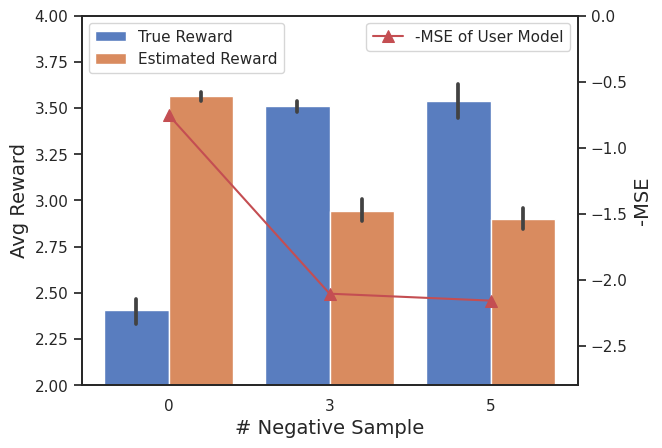

In [8]:
# barplot
sns.set(style="white")
colors = sns.color_palette(n_colors=10)

ax = sns.barplot(x="n_neg", y="value", hue="cate", data=reward_df[reward_df['cate']!="user_model"], palette="muted") # muted deep YlGnBu
ax.set_ylim(2.0, 4.0)
ax.set_ylabel("Avg Reward", fontsize=14)

ax2 = plt.twinx()
ax2.set_ylim(-2.8, 0)
ax2.set_ylabel("-MSE", fontsize=14)
sns.lineplot(ax=ax2, x="x", y="value", data=usermodel_df, label="-MSE of User Model",
             linewidth=1.5, marker='^', color=colors[3], markeredgecolor=colors[3], markersize=8)


ax.set_xlabel("# Negative Sample", fontsize=14)
ax.legend(ncol=1, loc="upper left", fontsize=11)
ax2.legend(ncol=1, loc="upper right", fontsize=11)
plt.savefig(os.path.join(save_fig_dir, savename + '.pdf'), format='pdf', bbox_inches='tight')
plt.savefig(os.path.join(save_fig_dir, savename + '.png'), format='png', bbox_inches='tight')
plt.show()